In [7]:
import dill
import pandas as pd
import numpy as np
from langchain.llms import Cohere, OpenAI, GooglePalm, Anthropic
from langchain.prompts import PromptTemplate
from langchain.output_parsers import PydanticOutputParser
from langchain.pydantic_v1 import BaseModel, Field, validator
from typing import List
from pypdf import PdfReader

# from langchain.chat_models import ChatCohere
# from langchain.prompts import ChatPromptTemplate, PromptTemplate
# from langchain.chains import ConversationChain
# from langchain.memory import ConversationBufferMemory
# from langchain.output_parsers import ResponseSchema, StructuredOutputParser, CommaSeparatedListOutputParser, PydanticOutputParser
# import cohere

from dotenv import load_dotenv, find_dotenv

_ = load_dotenv(find_dotenv())

# co = cohere.Client(os.environ['COHERE_API_KEY'])

# Load Data

Load data gathered in an excel spreadsheet

In [2]:
df = pd.read_excel(
    '../data/CSC869 Term Project Dataset.xlsx', 
    sheet_name='Course Descriptions', 
    skiprows=3, 
    names=['School', 'MATH226 eqv', 'MATH226 mult eqv', 'MATH226 alt eqv', 'MATH226 alt mult eqv', 'CSC230 eqv', 'CSC230 alt eqv', 'CSC256 eqv', 'CSC256 multipleEqv'],
    index_col=None
)
df = df.dropna(how='all').set_index("School")

In [3]:
math226_desc = df.iloc[0,0]
csc230_desc = df.iloc[0,4]
csc256_desc = df.iloc[0,6]
print(math226_desc, "\n\n")
print(csc230_desc, "\n\n")
print(csc256_desc)

MATH 226 - Calculus I
4 Units

Graphs. Differentiation: theory, techniques, and applications. Integration: Fundamental Theorem of Calculus and applications. Transcendental functions. 


CSC 230 - Discrete Mathematical Structures for Computer Science
3 Units

Review of set algebra, relations and functions, permutations, propositional logic, proof techniques, introduction to graph theory, and infinite sets, and their applications to computer science. 


CSC 256 - Machine Structures
3 Units

Digital logic circuits, data representation, assembly language programming, subroutine linkage, machine language encoding, interrupt and exception handling, memory system concepts, and CPU organization and performance.


In [4]:
df

,MATH226 eqv,MATH226 mult eqv,MATH226 alt eqv,MATH226 alt mult eqv,CSC230 eqv,CSC230 alt eqv,CSC256 eqv,CSC256 multipleEqv
School,,,,,,,,
SFSU,MATH 226 - Calculus I\n4 Units\n\nGraphs. Diff...,NaN,NaN,NaN,CSC 230 - Discrete Mathematical Structures for...,NaN,CSC 256 - Machine Structures\n3 Units\n\nDigit...,NaN
Berkeley City College,"MATH 3A - Calculus I\n5 Units, 5 lecture hours...",NaN,NaN,NaN,MATH 11 - Discrete Mathematics\n4 units\n\nN/A,NaN,CIS 20: Microcomputer Assembly Language\n4 Uni...,NaN
"California Polytechnic State University, Humboldt","MATH 109 - Calculus I\n4 Units, 4 Lecture hour...",NaN,NaN,NaN,"MATH 253 - Discrete Mathematics\n3 Units, 3 Le...",NaN,NaN,NaN
"California Polytechnic State University, Pomona",MAT 1140 - Calculus I\n4 Units\nPrerequisites:...,NaN,NaN,NaN,CS 1300 - Discrete Structures\n4 Units\nPrereq...,NaN,CS 2640 - Computer Organization and Assembly P...,NaN
"California Polytechnic State University, San Luis Obispo",MATH 141 - Calculus I\n4 Units\nGE Area B1\nPr...,MATH 142 - Calculus II\n4 units\nGE Area B1\nP...,HNRS 141 - Calculus I \n4 Units \nPrerequisite...,HNRS 142 - Calculus II \n4 units\nPrerequisite...,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
Solano Community College,MATH020:\n\n4.0 Units\nPrint\nDescription:\n\n...,NaN,NaN,NaN,CIS021:\n\n3.0 Units\nPrint\nDescription:\n\nA...,NaN,CIS020:\n\n3.0 Units\nPrint\nDescription:\n\nA...,NaN
Sonoma State University,MATH 161 - Differential and Integral Calculus ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ventura College,MATH V21A Calculus with Analytic Geometry I 5 ...,NaN,NaN,NaN,MATH V52 Discrete Structures 3 Units\nSame-As:...,CS V17 Discrete Structures 3 Units\nSame-As: M...,NaN,NaN


# Extract Topics

Exploration and testing of topic (and general data) extraction.

## Initialize LLM

In [5]:
# llm_cohere = ChatCohere(temperature=0)
# cgpt = OpenAI(model_name="text-davinci-003", temperature=0)
# cohere = Cohere(model="command", temperature=0)
palm = GooglePalm(model_name="models/text-bison-001", temperature=0)

## Create Course Class for Output Parsing

In [31]:
class Course(BaseModel):
    name: str = Field(description="name of the course")
    discipline: str = Field(description="academic discipline of the course")
    # add college name?
    topics: List[str] = Field(description="list of topics that the course covers")

course_parser = PydanticOutputParser(pydantic_object=Course)

## Create Prompt from Template

### Prompt Template for Prompt Generation

In [7]:
# Prompt Template to extract only course information
# course_query = """\
# For the course description, extract the course information.\n\
# {format_instructions}\n\n\
# This is the course description to be analyzed:\n```{course_desc}```\n
# """

course_prompt_template = """
For the course description, extract the course information.  Categorize the \
academic discipline that the course belongs to.\n
{format_instructions}\n\n
This is the course description to be analyzed:\n{course_desc}\n
"""

course_desc = df.iloc[2,4]

In [8]:
course_desc

'MATH 253 - Discrete Mathematics\n3 Units, 3 Lecture Hours\nPrerequisites: MATH 101T (C), or MATH 102 and CS 111\n\nSets, functions, relations, algorithms, induction, recursion, combinatorics, graphs, trees, and propositional logic.'

In [9]:
course_prompt = PromptTemplate(
    template=course_prompt_template,
    input_variables=["course_desc"],
    partial_variables={"format_instructions": course_parser.get_format_instructions()}
)

In [10]:
_input = course_prompt.format_prompt(course_desc=course_desc)

In [11]:
print(_input.to_string())


For the course description, extract the course information.  Categorize the academic discipline that the course belongs to.

The output should be formatted as a JSON instance that conforms to the JSON schema below.

As an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}
the object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.

Here is the output schema:
```
{"properties": {"name": {"title": "Name", "description": "name of the course", "type": "string"}, "discipline": {"title": "Discipline", "description": "academic discipline of the course", "type": "string"}, "topics": {"title": "Topics", "description": "list of topics that the course covers", "type": "array", "items": {"type": "string"}}}, "required": ["name", "discipline", "topics"]}
```


This is the course description

In [174]:
# output_cohere = cohere(_input.to_string())
# output_cgpt = cgpt(_input.to_string())

In [175]:
course_output_palm = palm(_input.to_string())

In [176]:
course_output_palm

'```\n{\n  "name": "MATH 253 - Discrete Mathematics",\n  "discipline": "Mathematics",\n  "topics": ["Sets", "Functions", "Relations", "Algorithms", "Induction", "Recursion", "Combinatorics", "Graphs", "Trees", "Propositional Logic"]\n}\n```'

In [177]:
course_data_palm = course_parser.parse(course_output_palm)

In [178]:
course_data_palm.discipline

'Mathematics'

# Process Entire DataFrame

Here, I take the exploration that was completed above to develop functions that
allow for our entire dataframe to be processed.

In [12]:
from tqdm.auto import tqdm

def process_course(course_desc: str):
    if course_desc is np.NaN:
        return np.NaN
    _input = prompt.format_prompt(course_desc=course_desc)
    result = palm(_input.to_string())
    return result

def process_all_courses(df: pd.DataFrame):
    for col in tqdm(df.columns, desc="Total Progress", position=0):
        df[f"{col} data"] = list(map(process_course, tqdm(df.loc[:, col], desc=f"{col}", position=1)))
    return df

In [13]:
toy_df = df.iloc[2:5].copy()
toy_df

,MATH226 eqv,MATH226 mult eqv,MATH226 alt eqv,MATH226 alt mult eqv,CSC230 eqv,CSC230 alt eqv,CSC256 eqv,CSC256 multipleEqv
School,,,,,,,,
"California Polytechnic State University, Humboldt","MATH 109 - Calculus I\n4 Units, 4 Lecture hour...",NaN,NaN,NaN,"MATH 253 - Discrete Mathematics\n3 Units, 3 Le...",NaN,NaN,NaN
"California Polytechnic State University, Pomona",MAT 1140 - Calculus I\n4 Units\nPrerequisites:...,NaN,NaN,NaN,CS 1300 - Discrete Structures\n4 Units\nPrereq...,NaN,CS 2640 - Computer Organization and Assembly P...,NaN
"California Polytechnic State University, San Luis Obispo",MATH 141 - Calculus I\n4 Units\nGE Area B1\nPr...,MATH 142 - Calculus II\n4 units\nGE Area B1\nP...,HNRS 141 - Calculus I \n4 Units \nPrerequisite...,HNRS 142 - Calculus II \n4 units\nPrerequisite...,NaN,NaN,NaN,NaN


In [14]:
# toy_df2 = process_all_courses(toy_df)
# toy_df2

In [15]:
# toy_df2.iloc[0,8]

In [16]:
# df2 = process_all_courses(df)

In [17]:
# df2

In [8]:
with open('../data/course_desc_and_data.pkl', 'wb') as f:
    dill.dump(df2, f)

with open('../data/course_desc_and_data.pkl', 'rb') as f:
    df2 = dill.load(f)

In [28]:
df2

,MATH226 eqv,MATH226 mult eqv,MATH226 alt eqv,MATH226 alt mult eqv,CSC230 eqv,CSC230 alt eqv,CSC256 eqv,CSC256 multipleEqv,MATH226 eqv data,MATH226 mult eqv data,MATH226 alt eqv data,MATH226 alt mult eqv data,CSC230 eqv data,CSC230 alt eqv data,CSC256 eqv data,CSC256 multipleEqv data
School,,,,,,,,,,,,,,,,
SFSU,MATH 226 - Calculus I\n4 Units\n\nGraphs. Diff...,NaN,NaN,NaN,CSC 230 - Discrete Mathematical Structures for...,NaN,CSC 256 - Machine Structures\n3 Units\n\nDigit...,NaN,"{""name"": ""MATH 226 - Calculus I"", ""discipline""...",NaN,NaN,NaN,"{""name"": ""CSC 230 - Discrete Mathematical Stru...",NaN,"```\n{\n ""name"": ""CSC 256 - Machine Structure...",NaN
Berkeley City College,"MATH 3A - Calculus I\n5 Units, 5 lecture hours...",NaN,NaN,NaN,MATH 11 - Discrete Mathematics\n4 units\n\nN/A,NaN,CIS 20: Microcomputer Assembly Language\n4 Uni...,NaN,"```\n{\n ""name"": ""MATH 3A - Calculus I"",\n ""...",NaN,NaN,NaN,"{""name"": ""MATH 11 - Discrete Mathematics"", ""di...",NaN,"```\n{\n ""name"": ""CIS 20: Microcomputer Assem...",NaN
"California Polytechnic State University, Humboldt","MATH 109 - Calculus I\n4 Units, 4 Lecture hour...",NaN,NaN,NaN,"MATH 253 - Discrete Mathematics\n3 Units, 3 Le...",NaN,NaN,NaN,"```\n{\n ""name"": ""MATH 109 - Calculus I"",\n ...",NaN,NaN,NaN,"```\n{\n ""name"": ""MATH 253 - Discrete Mathema...",NaN,NaN,NaN
"California Polytechnic State University, Pomona",MAT 1140 - Calculus I\n4 Units\nPrerequisites:...,NaN,NaN,NaN,CS 1300 - Discrete Structures\n4 Units\nPrereq...,NaN,CS 2640 - Computer Organization and Assembly P...,NaN,"```\n{\n ""name"": ""MAT 1140 - Calculus I"",\n ...",NaN,NaN,NaN,"```\n{\n ""name"": ""CS 1300 - Discrete Structur...",NaN,"```\n{\n ""name"": ""CS 2640 - Computer Organiza...",NaN
"California Polytechnic State University, San Luis Obispo",MATH 141 - Calculus I\n4 Units\nGE Area B1\nPr...,MATH 142 - Calculus II\n4 units\nGE Area B1\nP...,HNRS 141 - Calculus I \n4 Units \nPrerequisite...,HNRS 142 - Calculus II \n4 units\nPrerequisite...,NaN,NaN,NaN,NaN,"{""name"": ""MATH 141 - Calculus I"", ""discipline""...","```\n{\n ""name"": ""MATH 142 - Calculus II"",\n ...","```\n{\n ""name"": ""HNRS 141 - Calculus I"",\n ...","```\n{\n ""name"": ""HNRS 142 - Calculus II"",\n ...",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Solano Community College,MATH020:\n\n4.0 Units\nPrint\nDescription:\n\n...,NaN,NaN,NaN,CIS021:\n\n3.0 Units\nPrint\nDescription:\n\nA...,NaN,CIS020:\n\n3.0 Units\nPrint\nDescription:\n\nA...,NaN,"{""name"": ""MATH020"", ""discipline"": ""Mathematics...",NaN,NaN,NaN,"```\n{\n ""name"": ""CIS021"",\n ""discipline"": ""...",NaN,"{""name"": ""CIS020"", ""discipline"": ""Computer Sci...",NaN
Sonoma State University,MATH 161 - Differential and Integral Calculus ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"```\n{\n ""name"": ""MATH 161 - Differential and...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ventura College,MATH V21A Calculus with Analytic Geometry I 5 ...,NaN,NaN,NaN,MATH V52 Discrete Structures 3 Units\nSame-As:...,CS V17 Discrete Structures 3 Units\nSame-As: M...,NaN,NaN,"```\n{\n ""name"": ""MATH V21A Calculus with Ana...",NaN,NaN,NaN,"```\n{\n ""name"": ""MATH V52 Discrete Structure...","```\n{\n ""name"": ""CS V17 Discrete Structures""...",NaN,NaN


In [29]:
df2.iloc[0,8]

'{"name": "MATH 226 - Calculus I", "discipline": "Mathematics", "topics": ["Calculus", "Differentiation", "Integration", "Transcendental functions"]}'

In [32]:
course_data_palm = course_parser.parse(df2.iloc[0,8])
course_data_palm

Course(name='MATH 226 - Calculus I', discipline='Mathematics', topics=['Calculus', 'Differentiation', 'Integration', 'Transcendental functions'])

In [36]:
course_data_palm.topics

list

# Baseline Equivalency

Equivalency assessed from raw course description text

## Single pair of courses assessment

In [189]:
# Prompt Template for Course Equivalency prediction

equiv_prompt_template = """
Determine whether the two \
following courses are equivalent. For course equivalency, respond with 'true' \
or 'false'.\n
{format_instructions}\n
Course 1:\n```{course1_desc}```\n
Course 2:\n```{course2_desc}```
"""

In [227]:
from typing import Literal

class Equivalency(BaseModel):
    # courses: list[str] = Field(description="subject of the two courses to be evaluated")
    isEquiv: bool = Field(description="equivalency prediction")

equiv_parser = PydanticOutputParser(pydantic_object=Equivalency)

equiv_prompt = PromptTemplate(
    template=equiv_prompt_template,
    input_variables=["course1_desc", "course2_desc"],
    partial_variables={"format_instructions": equiv_parser.get_format_instructions()}
)

In [191]:
df.iloc[0,0]

'MATH 226 - Calculus I\n4 Units\n\nGraphs. Differentiation: theory, techniques, and applications. Integration: Fundamental Theorem of Calculus and applications. Transcendental functions.'

In [192]:
course1_desc = df.iloc[0,4]
course2_desc = df.iloc[2,4]
course3_desc = "\n".join(course2_desc.split("\n")[0:2]) + """\
\n\nSets, functions, relations, algorithms, induction, \
differentiation, integration, and transcentental functions."""
# + "\n\nSets, relations, induction, algorithms, differentiation, and limits."
print(course1_desc, "\n\n", course2_desc, "\n\n", course3_desc)

CSC 230 - Discrete Mathematical Structures for Computer Science
3 Units

Review of set algebra, relations and functions, permutations, propositional logic, proof techniques, introduction to graph theory, and infinite sets, and their applications to computer science. 

 MATH 253 - Discrete Mathematics
3 Units, 3 Lecture Hours
Prerequisites: MATH 101T (C), or MATH 102 and CS 111

Sets, functions, relations, algorithms, induction, recursion, combinatorics, graphs, trees, and propositional logic. 

 MATH 253 - Discrete Mathematics
3 Units, 3 Lecture Hours

Sets, functions, relations, algorithms, induction, differentiation, integration, and transcentental functions.


In [195]:
_input = equiv_prompt.format_prompt(course1_desc=course1_desc, course2_desc=course2_desc)
print(_input.to_string())


Determine whether the two following courses are equivalent. For course equivalency, respond with 'true' or 'false'.

The output should be formatted as a JSON instance that conforms to the JSON schema below.

As an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}
the object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.

Here is the output schema:
```
{"properties": {"isEquiv": {"title": "Isequiv", "description": "equivalency prediction", "type": "boolean"}}, "required": ["isEquiv"]}
```

Course 1:
```CSC 230 - Discrete Mathematical Structures for Computer Science
3 Units

Review of set algebra, relations and functions, permutations, propositional logic, proof techniques, introduction to graph theory, and infinite sets, and their applications to computer science.```

Course 

In [196]:
equiv_output_palm = palm(_input.to_string())
equiv_output_palm

'{"isEquiv": true}'

In [197]:
equiv_data_palm = equiv_parser.parse(equiv_output_palm)
equiv_data_palm

Equivalency(isEquiv=True)

# Create Positive and Negative Test Case Dataset

## Construct Positive Cases

The set of positive equivalencies were created from course articulation
agreements with SFSU only.  To expand the set of positive equivalencies, we
assume that any course from a college that has an articulated course with SFSU
is also equivalent to any other course from another college that has an
articulation agreement with SFSU.

By doing this, we increase the number of positive cases from $62$ to $1953$ for each
course, of which, we have 3 (Calculus I, Discrete Math, and Machine Structures).
So for each course we have
$$ C(n,k) = \frac{P(n,k)}{k!} = \frac{n!}{k!(n-k)!} $$
$$ C(63,2) = \frac{63!}{2(61!)} = \frac{63\cdot 62}{2} = 1953. $$
Then by applying this to all three cases, we construct $4259$ positive cases
($5859$ total positive pairs $- 1600$ unarticulated courses $= 4259$).

In [134]:
pairs_list = []
count = 0
df_test_cases = df2.iloc[:,[0, 4, 6, 8, 12, 14]]
for i in range(int(len(df_test_cases.columns)/2)):
    for j, desc in enumerate(df_test_cases.iloc[:,i]):
        for k in range(j+1,len(df_test_cases.iloc[:,i])):
            if (type(desc) is str) and (type(df_test_cases.iloc[k,i]) is str):
                pairs_list.append((desc, df_test_cases.iloc[k,i], df_test_cases.iloc[j,i+3], df_test_cases.iloc[k,i+3], 1))
            else:
                count += 1

In [135]:
len(pairs_list)

4259

##### Sanity Check

In [136]:
count

1600

In [137]:
len(pairs_list)

4259

In [138]:
count + len(pairs_list)

5859

In [139]:
df_eval = pd.DataFrame(pairs_list, columns=['target_raw', 'source_raw', 'target_topics', 'source_topics', 'label'])
df_eval

,target_raw,source_raw,target_topics,source_topics,label
0,MATH 226 - Calculus I\n4 Units\n\nGraphs. Diff...,"MATH 3A - Calculus I\n5 Units, 5 lecture hours...","{""name"": ""MATH 226 - Calculus I"", ""discipline""...","```\n{\n ""name"": ""MATH 3A - Calculus I"",\n ""...",1
1,MATH 226 - Calculus I\n4 Units\n\nGraphs. Diff...,"MATH 109 - Calculus I\n4 Units, 4 Lecture hour...","{""name"": ""MATH 226 - Calculus I"", ""discipline""...","```\n{\n ""name"": ""MATH 109 - Calculus I"",\n ...",1
2,MATH 226 - Calculus I\n4 Units\n\nGraphs. Diff...,MAT 1140 - Calculus I\n4 Units\nPrerequisites:...,"{""name"": ""MATH 226 - Calculus I"", ""discipline""...","```\n{\n ""name"": ""MAT 1140 - Calculus I"",\n ...",1
3,MATH 226 - Calculus I\n4 Units\n\nGraphs. Diff...,MATH 141 - Calculus I\n4 Units\nGE Area B1\nPr...,"{""name"": ""MATH 226 - Calculus I"", ""discipline""...","{""name"": ""MATH 141 - Calculus I"", ""discipline""...",1
4,MATH 226 - Calculus I\n4 Units\n\nGraphs. Diff...,MATH 150 - Calculus I\n4 Units\nFour hours lec...,"{""name"": ""MATH 226 - Calculus I"", ""discipline""...","```\n{\n ""name"": ""MATH 150 - Calculus I"",\n ...",1
...,...,...,...,...,...
4254,CSCI 0039. Introduction to Computer Architectu...,CIS020:\n\n3.0 Units\nPrint\nDescription:\n\nA...,"```\n{\n ""name"": ""CSCI 0039. Introduction to ...","{""name"": ""CIS020"", ""discipline"": ""Computer Sci...",1
4255,CSCI 0039. Introduction to Computer Architectu...,COMSC-2 3 UNITS\nComputer Assembly Language\nT...,"```\n{\n ""name"": ""CSCI 0039. Introduction to ...","```\n{\n ""name"": ""Computer Assembly Language""...",1
4256,COMP 256 Computer Architecture and Assembly La...,CIS020:\n\n3.0 Units\nPrint\nDescription:\n\nA...,"```\n{\n ""name"": ""COMP 256 Computer Architect...","{""name"": ""CIS020"", ""discipline"": ""Computer Sci...",1
4257,COMP 256 Computer Architecture and Assembly La...,COMSC-2 3 UNITS\nComputer Assembly Language\nT...,"```\n{\n ""name"": ""COMP 256 Computer Architect...","```\n{\n ""name"": ""Computer Assembly Language""...",1


In [27]:
df_eval.iloc[170]

target_raw       MATH 109 - Calculus I\n4 Units, 4 Lecture hour...
source_raw       MATH 150 Calculus with Analytic Geometry I (5 ...
target_topics    ```\n{\n  "name": "MATH 109 - Calculus I",\n  ...
source_topics    ```\n{\n  "name": "MATH 150 Calculus with Anal...
label                                                            1
Name: 170, dtype: object

## Sample for Negative Cases

This set of negative cases for course articulation is created by sampling
courses that are definitively not equivalent (e.g. Calculus I and Machine
Structures).

We want to keep the dataset balanced, so we will sample $4259/3 \approx 1420$
negative cases from each course type we are assessing.  The way we accomplish
this is by sampling the target courses and then sampling known negative cases
for equivalency from one of the other courses.

Example:
We randomly sample a set of courses from "MATH 226" equivalencies.  Then we match each of
those courses that we sampled with another random sample from a concatenated
Series from both "CSC 230" and "CSC 256" equivalencies.

In [38]:
df2

,MATH226 eqv,MATH226 mult eqv,MATH226 alt eqv,MATH226 alt mult eqv,CSC230 eqv,CSC230 alt eqv,CSC256 eqv,CSC256 multipleEqv,MATH226 eqv data,MATH226 mult eqv data,MATH226 alt eqv data,MATH226 alt mult eqv data,CSC230 eqv data,CSC230 alt eqv data,CSC256 eqv data,CSC256 multipleEqv data
School,,,,,,,,,,,,,,,,
SFSU,MATH 226 - Calculus I\n4 Units\n\nGraphs. Diff...,NaN,NaN,NaN,CSC 230 - Discrete Mathematical Structures for...,NaN,CSC 256 - Machine Structures\n3 Units\n\nDigit...,NaN,"{""name"": ""MATH 226 - Calculus I"", ""discipline""...",NaN,NaN,NaN,"{""name"": ""CSC 230 - Discrete Mathematical Stru...",NaN,"```\n{\n ""name"": ""CSC 256 - Machine Structure...",NaN
Berkeley City College,"MATH 3A - Calculus I\n5 Units, 5 lecture hours...",NaN,NaN,NaN,MATH 11 - Discrete Mathematics\n4 units\n\nN/A,NaN,CIS 20: Microcomputer Assembly Language\n4 Uni...,NaN,"```\n{\n ""name"": ""MATH 3A - Calculus I"",\n ""...",NaN,NaN,NaN,"{""name"": ""MATH 11 - Discrete Mathematics"", ""di...",NaN,"```\n{\n ""name"": ""CIS 20: Microcomputer Assem...",NaN
"California Polytechnic State University, Humboldt","MATH 109 - Calculus I\n4 Units, 4 Lecture hour...",NaN,NaN,NaN,"MATH 253 - Discrete Mathematics\n3 Units, 3 Le...",NaN,NaN,NaN,"```\n{\n ""name"": ""MATH 109 - Calculus I"",\n ...",NaN,NaN,NaN,"```\n{\n ""name"": ""MATH 253 - Discrete Mathema...",NaN,NaN,NaN
"California Polytechnic State University, Pomona",MAT 1140 - Calculus I\n4 Units\nPrerequisites:...,NaN,NaN,NaN,CS 1300 - Discrete Structures\n4 Units\nPrereq...,NaN,CS 2640 - Computer Organization and Assembly P...,NaN,"```\n{\n ""name"": ""MAT 1140 - Calculus I"",\n ...",NaN,NaN,NaN,"```\n{\n ""name"": ""CS 1300 - Discrete Structur...",NaN,"```\n{\n ""name"": ""CS 2640 - Computer Organiza...",NaN
"California Polytechnic State University, San Luis Obispo",MATH 141 - Calculus I\n4 Units\nGE Area B1\nPr...,MATH 142 - Calculus II\n4 units\nGE Area B1\nP...,HNRS 141 - Calculus I \n4 Units \nPrerequisite...,HNRS 142 - Calculus II \n4 units\nPrerequisite...,NaN,NaN,NaN,NaN,"{""name"": ""MATH 141 - Calculus I"", ""discipline""...","```\n{\n ""name"": ""MATH 142 - Calculus II"",\n ...","```\n{\n ""name"": ""HNRS 141 - Calculus I"",\n ...","```\n{\n ""name"": ""HNRS 142 - Calculus II"",\n ...",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Solano Community College,MATH020:\n\n4.0 Units\nPrint\nDescription:\n\n...,NaN,NaN,NaN,CIS021:\n\n3.0 Units\nPrint\nDescription:\n\nA...,NaN,CIS020:\n\n3.0 Units\nPrint\nDescription:\n\nA...,NaN,"{""name"": ""MATH020"", ""discipline"": ""Mathematics...",NaN,NaN,NaN,"```\n{\n ""name"": ""CIS021"",\n ""discipline"": ""...",NaN,"{""name"": ""CIS020"", ""discipline"": ""Computer Sci...",NaN
Sonoma State University,MATH 161 - Differential and Integral Calculus ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"```\n{\n ""name"": ""MATH 161 - Differential and...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ventura College,MATH V21A Calculus with Analytic Geometry I 5 ...,NaN,NaN,NaN,MATH V52 Discrete Structures 3 Units\nSame-As:...,CS V17 Discrete Structures 3 Units\nSame-As: M...,NaN,NaN,"```\n{\n ""name"": ""MATH V21A Calculus with Ana...",NaN,NaN,NaN,"```\n{\n ""name"": ""MATH V52 Discrete Structure...","```\n{\n ""name"": ""CS V17 Discrete Structures""...",NaN,NaN


In [58]:
df_test_cases

,MATH226 eqv,CSC230 eqv,CSC256 eqv,MATH226 eqv data,CSC230 eqv data,CSC256 eqv data
School,,,,,,
SFSU,MATH 226 - Calculus I\n4 Units\n\nGraphs. Diff...,CSC 230 - Discrete Mathematical Structures for...,CSC 256 - Machine Structures\n3 Units\n\nDigit...,"{""name"": ""MATH 226 - Calculus I"", ""discipline""...","{""name"": ""CSC 230 - Discrete Mathematical Stru...","```\n{\n ""name"": ""CSC 256 - Machine Structure..."
Berkeley City College,"MATH 3A - Calculus I\n5 Units, 5 lecture hours...",MATH 11 - Discrete Mathematics\n4 units\n\nN/A,CIS 20: Microcomputer Assembly Language\n4 Uni...,"```\n{\n ""name"": ""MATH 3A - Calculus I"",\n ""...","{""name"": ""MATH 11 - Discrete Mathematics"", ""di...","```\n{\n ""name"": ""CIS 20: Microcomputer Assem..."
"California Polytechnic State University, Humboldt","MATH 109 - Calculus I\n4 Units, 4 Lecture hour...","MATH 253 - Discrete Mathematics\n3 Units, 3 Le...",NaN,"```\n{\n ""name"": ""MATH 109 - Calculus I"",\n ...","```\n{\n ""name"": ""MATH 253 - Discrete Mathema...",NaN
"California Polytechnic State University, Pomona",MAT 1140 - Calculus I\n4 Units\nPrerequisites:...,CS 1300 - Discrete Structures\n4 Units\nPrereq...,CS 2640 - Computer Organization and Assembly P...,"```\n{\n ""name"": ""MAT 1140 - Calculus I"",\n ...","```\n{\n ""name"": ""CS 1300 - Discrete Structur...","```\n{\n ""name"": ""CS 2640 - Computer Organiza..."
"California Polytechnic State University, San Luis Obispo",MATH 141 - Calculus I\n4 Units\nGE Area B1\nPr...,NaN,NaN,"{""name"": ""MATH 141 - Calculus I"", ""discipline""...",NaN,NaN
...,...,...,...,...,...,...
Solano Community College,MATH020:\n\n4.0 Units\nPrint\nDescription:\n\n...,CIS021:\n\n3.0 Units\nPrint\nDescription:\n\nA...,CIS020:\n\n3.0 Units\nPrint\nDescription:\n\nA...,"{""name"": ""MATH020"", ""discipline"": ""Mathematics...","```\n{\n ""name"": ""CIS021"",\n ""discipline"": ""...","{""name"": ""CIS020"", ""discipline"": ""Computer Sci..."
Sonoma State University,MATH 161 - Differential and Integral Calculus ...,NaN,NaN,"```\n{\n ""name"": ""MATH 161 - Differential and...",NaN,NaN
Ventura College,MATH V21A Calculus with Analytic Geometry I 5 ...,MATH V52 Discrete Structures 3 Units\nSame-As:...,NaN,"```\n{\n ""name"": ""MATH V21A Calculus with Ana...","```\n{\n ""name"": ""MATH V52 Discrete Structure...",NaN


In [71]:
indices = df_test_cases.loc[:,'MATH226 eqv'].dropna().drop(columns=["School"]).sample(n=50).index

In [82]:
df_test_cases

,MATH226 eqv,CSC230 eqv,CSC256 eqv,MATH226 eqv data,CSC230 eqv data,CSC256 eqv data
School,,,,,,
SFSU,MATH 226 - Calculus I\n4 Units\n\nGraphs. Diff...,CSC 230 - Discrete Mathematical Structures for...,CSC 256 - Machine Structures\n3 Units\n\nDigit...,"{""name"": ""MATH 226 - Calculus I"", ""discipline""...","{""name"": ""CSC 230 - Discrete Mathematical Stru...","```\n{\n ""name"": ""CSC 256 - Machine Structure..."
Berkeley City College,"MATH 3A - Calculus I\n5 Units, 5 lecture hours...",MATH 11 - Discrete Mathematics\n4 units\n\nN/A,CIS 20: Microcomputer Assembly Language\n4 Uni...,"```\n{\n ""name"": ""MATH 3A - Calculus I"",\n ""...","{""name"": ""MATH 11 - Discrete Mathematics"", ""di...","```\n{\n ""name"": ""CIS 20: Microcomputer Assem..."
"California Polytechnic State University, Humboldt","MATH 109 - Calculus I\n4 Units, 4 Lecture hour...","MATH 253 - Discrete Mathematics\n3 Units, 3 Le...",NaN,"```\n{\n ""name"": ""MATH 109 - Calculus I"",\n ...","```\n{\n ""name"": ""MATH 253 - Discrete Mathema...",NaN
"California Polytechnic State University, Pomona",MAT 1140 - Calculus I\n4 Units\nPrerequisites:...,CS 1300 - Discrete Structures\n4 Units\nPrereq...,CS 2640 - Computer Organization and Assembly P...,"```\n{\n ""name"": ""MAT 1140 - Calculus I"",\n ...","```\n{\n ""name"": ""CS 1300 - Discrete Structur...","```\n{\n ""name"": ""CS 2640 - Computer Organiza..."
"California Polytechnic State University, San Luis Obispo",MATH 141 - Calculus I\n4 Units\nGE Area B1\nPr...,NaN,NaN,"{""name"": ""MATH 141 - Calculus I"", ""discipline""...",NaN,NaN
...,...,...,...,...,...,...
Solano Community College,MATH020:\n\n4.0 Units\nPrint\nDescription:\n\n...,CIS021:\n\n3.0 Units\nPrint\nDescription:\n\nA...,CIS020:\n\n3.0 Units\nPrint\nDescription:\n\nA...,"{""name"": ""MATH020"", ""discipline"": ""Mathematics...","```\n{\n ""name"": ""CIS021"",\n ""discipline"": ""...","{""name"": ""CIS020"", ""discipline"": ""Computer Sci..."
Sonoma State University,MATH 161 - Differential and Integral Calculus ...,NaN,NaN,"```\n{\n ""name"": ""MATH 161 - Differential and...",NaN,NaN
Ventura College,MATH V21A Calculus with Analytic Geometry I 5 ...,MATH V52 Discrete Structures 3 Units\nSame-As:...,NaN,"```\n{\n ""name"": ""MATH V21A Calculus with Ana...","```\n{\n ""name"": ""MATH V52 Discrete Structure...",NaN


In [114]:
df_source = df_test_cases.drop(df_test_cases.columns[[0, 3]], axis=1)
df_source

,CSC230 eqv,CSC256 eqv,CSC230 eqv data,CSC256 eqv data
School,,,,
SFSU,CSC 230 - Discrete Mathematical Structures for...,CSC 256 - Machine Structures\n3 Units\n\nDigit...,"{""name"": ""CSC 230 - Discrete Mathematical Stru...","```\n{\n ""name"": ""CSC 256 - Machine Structure..."
Berkeley City College,MATH 11 - Discrete Mathematics\n4 units\n\nN/A,CIS 20: Microcomputer Assembly Language\n4 Uni...,"{""name"": ""MATH 11 - Discrete Mathematics"", ""di...","```\n{\n ""name"": ""CIS 20: Microcomputer Assem..."
"California Polytechnic State University, Humboldt","MATH 253 - Discrete Mathematics\n3 Units, 3 Le...",NaN,"```\n{\n ""name"": ""MATH 253 - Discrete Mathema...",NaN
"California Polytechnic State University, Pomona",CS 1300 - Discrete Structures\n4 Units\nPrereq...,CS 2640 - Computer Organization and Assembly P...,"```\n{\n ""name"": ""CS 1300 - Discrete Structur...","```\n{\n ""name"": ""CS 2640 - Computer Organiza..."
"California Polytechnic State University, San Luis Obispo",NaN,NaN,NaN,NaN
...,...,...,...,...
Solano Community College,CIS021:\n\n3.0 Units\nPrint\nDescription:\n\nA...,CIS020:\n\n3.0 Units\nPrint\nDescription:\n\nA...,"```\n{\n ""name"": ""CIS021"",\n ""discipline"": ""...","{""name"": ""CIS020"", ""discipline"": ""Computer Sci..."
Sonoma State University,NaN,NaN,NaN,NaN
Ventura College,MATH V52 Discrete Structures 3 Units\nSame-As:...,NaN,"```\n{\n ""name"": ""MATH V52 Discrete Structure...",NaN


In [113]:
df_source = pd.concat([df_source.iloc[:,0], df_source.iloc[:, 1]]).dropna().sample(n=1420, replace=True)
df_source

School
Pasadena City College                       CS 066  ASSEMBLY LANGUAGE PROGRAMMING FOR THE ...
Skyline College                             COMP 262 Discrete Mathematics for Computer Sci...
Santa Barbara City College                  CS 107 Computer Architecture and Organization ...
California State University, Bakersfield    CMPS 2120 - Discrete Structures\n4 Units\n\nDi...
Sierra College                              MATH 0015. Discrete Mathematics\n\nUnits: 4\nP...
                                                                  ...                        
Gavilan College                             CSIS 26 - Discrete Structures\n3 Units\n\nTopi...
Santa Monica College                        MATH 10\nDiscrete Structures\nUnits: 3\nTransf...
Reedley College                             26 DISCRETE MATHEMATICS FOR\nCOMPUTER SCIENCE\...
Mount San Antonio College                   CSCI 150  Assembly Language/Machine Architectu...
City College of San Francisco               CS 270, C

In [115]:
df_source = df_test_cases.drop(df_test_cases.columns[[0, 3]], axis=1)
df_source = df_test_cases.drop(df_test_cases.columns[[i, i+3]], axis=1)
source_raw_col = pd.concat([df_source.iloc[:, 0], df_source.iloc[:, 1]], axis=0).dropna().reset_index()
source_topic_col = pd.concat([df_source.iloc[:, 2], df_source.iloc[:, 3]], axis=0).dropna().reset_index()
source_indices = source_raw_col.sample(n=1420, replace=True).index

In [121]:
source_raw_col.iloc[source_indices, 1]

14     MATH 122 - Calculus I\n4 Units\n\nPrerequisite...
61     MATH-1A 4 UNITS\nSingle Variable Calculus I - ...
60     MATH 003A: Calculus and Analytical Geometry\nC...
108    MATH 4 Discrete Mathematics\n\n4 Units/4 hours...
18     MATH 30 - Calculus I\n4 Units\nPrerequisite(s)...
                             ...                        
58     MATH 161 - Differential and Integral Calculus ...
54     MATH 1A Calculus, First Course\n\n5 Units/5 ho...
102    CS 045  DISCRETE STRUCTURES WITH COMPUTER SCIE...
58     MATH 161 - Differential and Integral Calculus ...
28     MATH 400 - Calculus I\n5 Units\nPrerequisite: ...
Name: 0, Length: 1420, dtype: object

In [122]:
source_topic_col.iloc[source_indices, 1]

14     {"name": "MATH 122 - Calculus I", "discipline"...
61     ```\n{\n  "name": "MATH-1A",\n  "discipline": ...
60     ```\n{\n  "name": "MATH 003A: Calculus and Ana...
108    {"name": "MATH 4 Discrete Mathematics", "disci...
18     {"name": "MATH 30 - Calculus I", "discipline":...
                             ...                        
58     ```\n{\n  "name": "MATH 161 - Differential and...
54     {"name": "MATH 1A Calculus, First Course", "di...
102    {"name": "CS 045  DISCRETE STRUCTURES WITH COM...
58     ```\n{\n  "name": "MATH 161 - Differential and...
28     {"name": "MATH 400 - Calculus I", "discipline"...
Name: 0, Length: 1420, dtype: object

In [124]:
target_indices = df_test_cases.iloc[:,0].dropna().sample(n=1420, replace=True).index
target_indices
# target_raw = df_test_cases.iloc[target_indices, 0]

Index(['Mount San Antonio College',
       'California Polytechnic State University, Pomona',
       'California State University, Stanislaus', 'Reedley College',
       'Merced Community College', 'California State University, Long Beach',
       'California Polytechnic State University, Humboldt',
       'Clovis Community College', 'Foothill College',
       'Sonoma State University',
       ...
       'City College of San Francisco', 'SFSU',
       'California State University, Dominguez Hills',
       'California State University, Los Angeles',
       'California Polytechnic State University, Pomona', 'SFSU',
       'Contra Costa College', 'Grossmont College', 'Ohlone College',
       'Chabot College'],
      dtype='object', name='School', length=1420)

In [128]:
df_test_cases.loc[target_indices].iloc[:,0]

School
Mount San Antonio College                          MATH 180  Calculus and Analytic Geometry I\n\n...
California Polytechnic State University, Pomona    MAT 1140 - Calculus I\n4 Units\nPrerequisites:...
California State University, Stanislaus            MATH 1410 - Calculus I\n4 Units\n\nInequalitie...
Reedley College                                    5A CALCULUS I\n5 units, 5 lecture hours\nPRERE...
Merced Community College                           MATH-04A - CALCULUS I\n4 units: 4 hours lectur...
                                                                         ...                        
SFSU                                               MATH 226 - Calculus I\n4 Units\n\nGraphs. Diff...
Contra Costa College                               MATH-190 Analytic Geometry and Calculus I\n\n5...
Grossmont College                                  MATH 180 - ANALYTIC GEOMETRY AND CALCULUS I\n5...
Ohlone College                                     Calculus with Analytic Geometry\n

In [140]:
target_sample = []
for i in range(3):
    target_indices = df_test_cases.iloc[:,i].dropna().sample(n=1420, replace=True).index
    target_raw = df_test_cases.loc[target_indices].iloc[:,i]
    target_topic = df_test_cases.loc[target_indices].iloc[:,i+3]

    df_source = df_test_cases.drop(df_test_cases.columns[[i, i+3]], axis=1)
    source_raw_col = pd.concat([df_source.iloc[:, 0], df_source.iloc[:, 1]], axis=0).dropna().reset_index()
    source_topic_col = pd.concat([df_source.iloc[:, 2], df_source.iloc[:, 3]], axis=0).dropna().reset_index()
    source_indices = source_raw_col.sample(n=1420, replace=True).index

    target_sample.append(list(zip(target_raw, source_raw_col.iloc[source_indices, 1], target_topic, source_topic_col.iloc[source_indices, 1], [0 for i in range(len(target_indices))])))

In [141]:
target_sample[0]

[("Math 2510 - Single Variable Calculus I\n4 Units\n\nA first course in single variable calculus. \nTopics include: Definition and computation of limits using numerical, graphical, and algebraic approaches; Continuity and differential ability of functions; Derivative as a limit; Interpretation of the derivative as: slope of tangent line, a rate of change; Differentiation formulas: constants, power rule, product rule, quotient rule and chain rule; Derivatives of transcendental functions such as trigonometric, exponential or logarithmic; Implicit differentiation with applications, and differentiation of inverse functions; Higher-order derivatives; Graphing functions using first and second derivatives, concavity and asymptotes; Indeterminate forms and L'Hopital's Rule; Maximum and minimum values, and optimization; Mean Value Theorem; Antiderivatives and indefinite integrals; Area under a curve; Definite integral; Riemann sum; Properties of the integral; Fundamental Theorem of Calculus; In

In [ ]:
target_sample = []
for i in range(3):
    target_raw = list(df_test_cases.iloc[:,i].dropna().sample(n=1420, replace=True))
    source_raw = df_test_cases.drop(df_test_cases.columns[[i]], axis=1)
    source_raw = list(pd.concat([source.iloc[:,0], source.iloc[:, 1]]).dropna().sample(n=1420, replace=True))
    target_topics = list(df_test_cases.iloc[:,i].dropna().sample(n=1420, replace=True))
    source_topics = df_test_cases.drop(df_test_cases.columns[[i]], axis=1)
    source_topics = list(pd.concat([source.iloc[:,0], source.iloc[:, 1]]).dropna().sample(n=1420, replace=True))
    target_sample.append(list(zip(target, source, [0 for i in range(len(target))])))

In [142]:
for course in target_sample:
    df_eval = pd.concat([df_eval, pd.DataFrame(course, columns=['target_raw', 'source_raw', 'target_topics', 'source_topics', 'label'])])

In [144]:
df_eval = df_eval.reset_index().drop(columns=['index'])

In [147]:
df_eval

,target_raw,source_raw,target_topics,source_topics,label
0,MATH 226 - Calculus I\n4 Units\n\nGraphs. Diff...,"MATH 3A - Calculus I\n5 Units, 5 lecture hours...","{""name"": ""MATH 226 - Calculus I"", ""discipline""...","```\n{\n ""name"": ""MATH 3A - Calculus I"",\n ""...",1
1,MATH 226 - Calculus I\n4 Units\n\nGraphs. Diff...,"MATH 109 - Calculus I\n4 Units, 4 Lecture hour...","{""name"": ""MATH 226 - Calculus I"", ""discipline""...","```\n{\n ""name"": ""MATH 109 - Calculus I"",\n ...",1
2,MATH 226 - Calculus I\n4 Units\n\nGraphs. Diff...,MAT 1140 - Calculus I\n4 Units\nPrerequisites:...,"{""name"": ""MATH 226 - Calculus I"", ""discipline""...","```\n{\n ""name"": ""MAT 1140 - Calculus I"",\n ...",1
3,MATH 226 - Calculus I\n4 Units\n\nGraphs. Diff...,MATH 141 - Calculus I\n4 Units\nGE Area B1\nPr...,"{""name"": ""MATH 226 - Calculus I"", ""discipline""...","{""name"": ""MATH 141 - Calculus I"", ""discipline""...",1
4,MATH 226 - Calculus I\n4 Units\n\nGraphs. Diff...,MATH 150 - Calculus I\n4 Units\nFour hours lec...,"{""name"": ""MATH 226 - Calculus I"", ""discipline""...","```\n{\n ""name"": ""MATH 150 - Calculus I"",\n ...",1
...,...,...,...,...,...
8514,CS 51 (C-ID COMP 142) 3 units \nIntr...,CSCI 190 Discrete Mathematics Applied to Comp...,"```\n{\n ""name"": ""CS 51"",\n ""discipline"": ""C...","```\n{\n ""name"": ""CSCI 190 Discrete Mathemat...",0
8515,CIS020:\n\n3.0 Units\nPrint\nDescription:\n\nA...,COMP 256 - Discrete Structures for Computer Sc...,"{""name"": ""CIS020"", ""discipline"": ""Computer Sci...","```\n{\n ""name"": ""COMP 256 - Discrete Structu...",0
8516,CIS020:\n\n3.0 Units\nPrint\nDescription:\n\nA...,MATH 170A - Mathematical Structures I\n3 Units...,"{""name"": ""CIS020"", ""discipline"": ""Computer Sci...","{""name"": ""MATH 170A - Mathematical Structures ...",0
8517,COMSC-2 3 UNITS\nComputer Assembly Language\nT...,MATH 1410 - Calculus I\n4 Units\n\nInequalitie...,"```\n{\n ""name"": ""Computer Assembly Language""...","{""name"": ""MATH 1410 - Calculus I"", ""discipline...",0


In [145]:
df_eval.iloc[-5:,0]

8514    CS 51  (C-ID COMP 142)         3 units  \nIntr...
8515    CIS020:\n\n3.0 Units\nPrint\nDescription:\n\nA...
8516    CIS020:\n\n3.0 Units\nPrint\nDescription:\n\nA...
8517    COMSC-2 3 UNITS\nComputer Assembly Language\nT...
8518    Introduction to Assembly Language Programming\...
Name: target_raw, dtype: object

In [146]:
df_eval.iloc[-5:,1]

8514    CSCI 190  Discrete Mathematics Applied to Comp...
8515    COMP 256 - Discrete Structures for Computer Sc...
8516    MATH 170A - Mathematical Structures I\n3 Units...
8517    MATH 1410 - Calculus I\n4 Units\n\nInequalitie...
8518    MATH 1A - CALCULUS\n5 Units\n\nPrerequisite:  ...
Name: source_raw, dtype: object

In [ ]:
with open('../data/df_eval.pkl', 'wb') as f:
    dill.dump(df_eval, f)

# with open('../data/df_eval.pkl', 'rb') as f:
#     df_eval = dill.load(f)

## Pairwise Equivalency Assessment using Raw Text (FULL DATASET)

In [1]:
def isEquivRaw(target, source):
    _input = equiv_prompt.format_prompt(course1_desc=target, course2_desc=source)
    # print(_input.to_string())
    res = palm(_input.to_string())
    # print(f"Response: {res}")
    res = equiv_parser.parse(res)
    # print(f"Parsed Response: {res.isEquiv}")
    if res.isEquiv == True:
        return 1
    else:
        return 0

In [2]:
def processRaw(preds):
    if preds:
        start = len(preds)
    else:
        start = 0
    step = int(len(df_eval)/50)
    for i in tqdm(range(start,len(df_eval), step), desc="Total Progress", position=0):
        if i + step < len(df_eval):
            preds.extend(list(map(isEquivRaw, tqdm(df_eval.iloc[i:i+step,0], desc=f"Batch Progress: {int((i-start+step)/170)}", position=1, leave=True), df_eval.iloc[i:i+step,1])))
            # print(f"Saving Progress: {i+step}")
            with open(f"../data/chunks/raw_text/preds_raw_0-{i+step}.pkl", "wb") as f:
                dill.dump(preds, f)
            # time.sleep(30)
        else:
            preds.extend(list(map(isEquivRaw, tqdm(df_eval.iloc[i:,0], desc=f"Batch Progress: {int((len(df_eval)-start)/170)+1}", position=1, leave=True), df_eval.iloc[i:,1])))
            with open(f"../data/chunks/raw_text/preds_raw_final.pkl", "wb") as f:
                dill.dump(preds, f)
            print("Finished")

In [281]:
df_eval["label"][:5780]

0       1
1       1
2       1
3       1
4       1
       ..
5775    0
5776    0
5777    0
5778    0
5779    0
Name: label, Length: 5780, dtype: int64

In [293]:
df_eval["pred"] = preds

In [303]:
df_eval.iloc[:,2].value_counts()

label
0    4260
1    4259
Name: count, dtype: int64

In [302]:
df_eval.iloc[:,3].value_counts()

pred
0    7292
1    1227
Name: count, dtype: int64

In [283]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

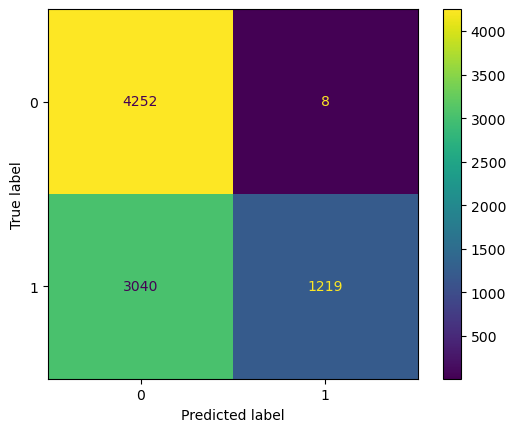

In [292]:
disp = ConfusionMatrixDisplay(confusion_matrix(df_eval["label"][:], preds[:]))
disp.plot()

# Topic Equivalency



In [29]:
# Prompt Template for Course Equivalency prediction

topicequiv_prompt_template = """
Given the discipline and list of topics for the two courses below, determine whether the two \
are equivalent. For course equivalency, respond with 'true' or 'false'.\n
{format_instructions}\n
Course 1 Discipline: ```{course1_disc}```\nCourse 1 Topics: ```{course1_topics}```\n
Course 2 Discipline: ```{course2_disc}```\nCourse 2 Topics: ```{course2_topics}``````
"""

In [30]:
class TopicEquivalency(BaseModel):
    isEquiv: bool = Field(description="equivalency prediction")

topicequiv_parser = PydanticOutputParser(pydantic_object=TopicEquivalency)

topicequiv_prompt = PromptTemplate(
    template=topicequiv_prompt_template,
    input_variables=["course1_disc", "course1_topics", "course2_disc", "course2_topics"],
    partial_variables={"format_instructions": topicequiv_parser.get_format_instructions()}
)

In [32]:
df2.iloc[0,8]

'{"name": "MATH 226 - Calculus I", "discipline": "Mathematics", "topics": ["Calculus", "Differentiation", "Integration", "Transcendental functions"]}'

In [40]:
course1_data = course_parser.parse(df2.iloc[0,8])
course2_data = course_parser.parse(df2.iloc[2,8])
course3_data = course_parser.parse(df2.iloc[0,8])
course3_data.topics = [ "Sets", "functions", "relations", "algorithms", "induction",
                        "differentiation", "integration", "transcentental", "functions" ]
print(", ".join(course1_data.topics), "\n\n", ", ".join(course2_data.topics), "\n\n", ", ".join(course3_data.topics))

Calculus, Differentiation, Integration, Transcendental functions 

 Limits, Continuity, Derivatives, Integrals 

 Sets, functions, relations, algorithms, induction, differentiation, integration, transcentental, functions


In [42]:
_input = topicequiv_prompt.format_prompt(
    course1_disc=course1_data.discipline, 
    course1_topics=course1_data.topics,
    course2_disc=course3_data.discipline, 
    course2_topics=course3_data.topics
)
print(_input.to_string())


Given the discipline and list of topics for the two courses below, determine whether the two are equivalent. For course equivalency, respond with 'true' or 'false'.

The output should be formatted as a JSON instance that conforms to the JSON schema below.

As an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}
the object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.

Here is the output schema:
```
{"properties": {"isEquiv": {"title": "Isequiv", "description": "equivalency prediction", "type": "boolean"}}, "required": ["isEquiv"]}
```

Course 1 Discipline: ```Mathematics```
Course 1 Topics: ```['Calculus', 'Differentiation', 'Integration', 'Transcendental functions']```

Course 2 Discipline: ```Mathematics```
Course 2 Topics: ```['Sets', 'functions', 'relations', 'algorithm

In [43]:
topicequiv_output_palm = palm(_input.to_string())
topicequiv_output_palm

'{"isEquiv": false}'

In [44]:
topicequiv_data_palm = topicequiv_parser.parse(topicequiv_output_palm)
topicequiv_data_palm

TopicEquivalency(isEquiv=False)

## Pairwise Equivalency Assessment using Topics and Discipline (FULL DATASET)

### Create Positive and Negative Test Case Dataset

#### Construct Positive Cases

The set of positive equivalencies were created from course articulation
agreements with SFSU only.  To expand the set of positive equivalencies, we
assume that any course from a college that has an articulated course with SFSU
is also equivalent to any other course from another college that has an
articulation agreement with SFSU.

By doing this, we increase the number of positive cases from $62$ to $1953$ for each
course, of which, we have 3 (Calculus I, Discrete Math, and Machine Structures).
So for each course we have
$$ C(n,k) = \frac{P(n,k)}{k!} = \frac{n!}{k!(n-k)!} $$
$$ C(63,2) = \frac{63!}{2(61!)} = \frac{63\cdot 62}{2} = 1953. $$
Then by applying this to all three cases, we construct $4259$ positive cases
($5859$ total positive pairs $- 1600$ unarticulated courses $= 4259$).

In [305]:
df2

,MATH226 eqv,MATH226 mult eqv,MATH226 alt eqv,MATH226 alt mult eqv,CSC230 eqv,CSC230 alt eqv,CSC256 eqv,CSC256 multipleEqv,MATH226 eqv data,MATH226 mult eqv data,MATH226 alt eqv data,MATH226 alt mult eqv data,CSC230 eqv data,CSC230 alt eqv data,CSC256 eqv data,CSC256 multipleEqv data
School,,,,,,,,,,,,,,,,
SFSU,MATH 226 - Calculus I\n4 Units\n\nGraphs. Diff...,NaN,NaN,NaN,CSC 230 - Discrete Mathematical Structures for...,NaN,CSC 256 - Machine Structures\n3 Units\n\nDigit...,NaN,"{""name"": ""MATH 226 - Calculus I"", ""discipline""...",NaN,NaN,NaN,"{""name"": ""CSC 230 - Discrete Mathematical Stru...",NaN,"```\n{\n ""name"": ""CSC 256 - Machine Structure...",NaN
Berkeley City College,"MATH 3A - Calculus I\n5 Units, 5 lecture hours...",NaN,NaN,NaN,MATH 11 - Discrete Mathematics\n4 units\n\nN/A,NaN,CIS 20: Microcomputer Assembly Language\n4 Uni...,NaN,"```\n{\n ""name"": ""MATH 3A - Calculus I"",\n ""...",NaN,NaN,NaN,"{""name"": ""MATH 11 - Discrete Mathematics"", ""di...",NaN,"```\n{\n ""name"": ""CIS 20: Microcomputer Assem...",NaN
"California Polytechnic State University, Humboldt","MATH 109 - Calculus I\n4 Units, 4 Lecture hour...",NaN,NaN,NaN,"MATH 253 - Discrete Mathematics\n3 Units, 3 Le...",NaN,NaN,NaN,"```\n{\n ""name"": ""MATH 109 - Calculus I"",\n ...",NaN,NaN,NaN,"```\n{\n ""name"": ""MATH 253 - Discrete Mathema...",NaN,NaN,NaN
"California Polytechnic State University, Pomona",MAT 1140 - Calculus I\n4 Units\nPrerequisites:...,NaN,NaN,NaN,CS 1300 - Discrete Structures\n4 Units\nPrereq...,NaN,CS 2640 - Computer Organization and Assembly P...,NaN,"```\n{\n ""name"": ""MAT 1140 - Calculus I"",\n ...",NaN,NaN,NaN,"```\n{\n ""name"": ""CS 1300 - Discrete Structur...",NaN,"```\n{\n ""name"": ""CS 2640 - Computer Organiza...",NaN
"California Polytechnic State University, San Luis Obispo",MATH 141 - Calculus I\n4 Units\nGE Area B1\nPr...,MATH 142 - Calculus II\n4 units\nGE Area B1\nP...,HNRS 141 - Calculus I \n4 Units \nPrerequisite...,HNRS 142 - Calculus II \n4 units\nPrerequisite...,NaN,NaN,NaN,NaN,"{""name"": ""MATH 141 - Calculus I"", ""discipline""...","```\n{\n ""name"": ""MATH 142 - Calculus II"",\n ...","```\n{\n ""name"": ""HNRS 141 - Calculus I"",\n ...","```\n{\n ""name"": ""HNRS 142 - Calculus II"",\n ...",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Solano Community College,MATH020:\n\n4.0 Units\nPrint\nDescription:\n\n...,NaN,NaN,NaN,CIS021:\n\n3.0 Units\nPrint\nDescription:\n\nA...,NaN,CIS020:\n\n3.0 Units\nPrint\nDescription:\n\nA...,NaN,"{""name"": ""MATH020"", ""discipline"": ""Mathematics...",NaN,NaN,NaN,"```\n{\n ""name"": ""CIS021"",\n ""discipline"": ""...",NaN,"{""name"": ""CIS020"", ""discipline"": ""Computer Sci...",NaN
Sonoma State University,MATH 161 - Differential and Integral Calculus ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"```\n{\n ""name"": ""MATH 161 - Differential and...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ventura College,MATH V21A Calculus with Analytic Geometry I 5 ...,NaN,NaN,NaN,MATH V52 Discrete Structures 3 Units\nSame-As:...,CS V17 Discrete Structures 3 Units\nSame-As: M...,NaN,NaN,"```\n{\n ""name"": ""MATH V21A Calculus with Ana...",NaN,NaN,NaN,"```\n{\n ""name"": ""MATH V52 Discrete Structure...","```\n{\n ""name"": ""CS V17 Discrete Structures""...",NaN,NaN


In [312]:
pairs_list = []
count = 0
df_top = df2.iloc[:,[8, 12, 14]]
for i in range(len(df_top.columns)):
    for j, desc in enumerate(df_top.iloc[:,i]):
        for k in range(j+1,len(df_top.iloc[:,i])):
            if (type(desc) is str) and (type(df_top.iloc[k,i]) is str):
                pairs_list.append((desc, df_top.iloc[k,i], 1))
            else:
                count += 1

##### Sanity Check

In [314]:
count

1600

In [315]:
len(pairs_list)

4259

In [316]:
count + len(pairs_list)

5859

In [317]:
df_eval = pd.DataFrame(pairs_list, columns=['target', 'source', 'label'])
df_eval

,target,source,label
0,"{""name"": ""MATH 226 - Calculus I"", ""discipline""...","```\n{\n ""name"": ""MATH 3A - Calculus I"",\n ""...",1
1,"{""name"": ""MATH 226 - Calculus I"", ""discipline""...","```\n{\n ""name"": ""MATH 109 - Calculus I"",\n ...",1
2,"{""name"": ""MATH 226 - Calculus I"", ""discipline""...","```\n{\n ""name"": ""MAT 1140 - Calculus I"",\n ...",1
3,"{""name"": ""MATH 226 - Calculus I"", ""discipline""...","{""name"": ""MATH 141 - Calculus I"", ""discipline""...",1
4,"{""name"": ""MATH 226 - Calculus I"", ""discipline""...","```\n{\n ""name"": ""MATH 150 - Calculus I"",\n ...",1
...,...,...,...
4254,"```\n{\n ""name"": ""CSCI 0039. Introduction to ...","{""name"": ""CIS020"", ""discipline"": ""Computer Sci...",1
4255,"```\n{\n ""name"": ""CSCI 0039. Introduction to ...","```\n{\n ""name"": ""Computer Assembly Language""...",1
4256,"```\n{\n ""name"": ""COMP 256 Computer Architect...","{""name"": ""CIS020"", ""discipline"": ""Computer Sci...",1
4257,"```\n{\n ""name"": ""COMP 256 Computer Architect...","```\n{\n ""name"": ""Computer Assembly Language""...",1


In [318]:
df_eval.iloc[170]

target    ```\n{\n  "name": "MATH 109 - Calculus I",\n  ...
source    ```\n{\n  "name": "MATH 150 Calculus with Anal...
label                                                     1
Name: 170, dtype: object

#### Sample for Negative Cases

This set of negative cases for course articulation is created by sampling
courses that are definitively not equivalent (e.g. Calculus I and Machine
Structures).

We want to keep the dataset balanced, so we will sample $4259/3 \approx 1420$
negative cases from each course type we are assessing.  The way we accomplish
this is by sampling the target courses and then sampling known negative cases
for equivalency from one of the other courses.

Example:
We randomly sample a set of courses from "MATH 226" equivalencies.  Then we match each of
those courses that we sampled with another random sample from a concatenated
Series from both "CSC 230" and "CSC 256" equivalencies.

In [319]:
target_sample = []
for i in range(3):
    target = list(df_top.iloc[:,i].dropna().sample(n=1420, replace=True))
    source = df_top.drop(df_top.columns[[i]], axis=1)
    source = list(pd.concat([source.iloc[:,0], source.iloc[:, 1]]).dropna().sample(n=1420, replace=True))
    target_sample.append(list(zip(target, source, [0 for i in range(len(target))])))

In [320]:
for course in target_sample:
    df_eval = pd.concat([df_eval, pd.DataFrame(course, columns=['target', 'source', 'label'])])

In [321]:
df_eval = df_eval.reset_index().drop(columns=['index'])

In [322]:
df_eval.iloc[-5:,0]

8514    ```\n{\n  "name": "CS 066  ASSEMBLY LANGUAGE P...
8515    {"name": "COMP-265 Assembly Language Programmi...
8516    {"name": "CIS 264 Computer Organization and Sy...
8517    {"name": "CS/IS 165 - COMPUTER ARCHITECTURE AN...
8518    {"name": "CSIS 28 - Computer Architecture", "d...
Name: target, dtype: object

In [323]:
df_eval.iloc[-5:,1]

8514    ```\n{\n  "name": "MATH 42 - Discrete Mathemat...
8515    ```\n{\n  "name": "MATH 253 - Discrete Mathema...
8516    {"name": "CS 045  DISCRETE STRUCTURES WITH COM...
8517    {"name": "CS/IS 125 - DISCRETE STRUCTURES FOR ...
8518    {"name": "MATH 3A - Calculus I", "discipline":...
Name: source, dtype: object

In [324]:
def isEquivTopics(target, source):
    target = course_parser.parse(target)
    source = course_parser.parse(source)
    _input = topicequiv_prompt.format_prompt(
        course1_disc=target.discipline, 
        course1_topics=target.topics,
        course2_disc=source.discipline, 
        course2_topics=source.topics
    )
    # print(_input.to_string())
    res = palm(_input.to_string())
    # print(f"Response: {res}")
    res = topicequiv_parser.parse(res)
    # print(f"Parsed Response: {res.isEquiv}")
    if res.isEquiv == True:
        return 1
    else:
        return 0

In [343]:
df_eval.iloc[10,0]

'{"name": "MATH 226 - Calculus I", "discipline": "Mathematics", "topics": ["Calculus", "Differentiation", "Integration", "Transcendental functions"]}'

In [344]:
df_eval.iloc[10,1]

'{"name": "MATH 130 - Calculus I", "discipline": "Mathematics", "topics": ["Calculus", "Limits", "Derivatives", "Optimization", "Antiderivatives", "Integration", "Fundamental Theorem of Calculus"]}'

In [345]:
df_eval.iloc[10,2]

1

In [342]:
isEquivTopics(df_eval.iloc[10,0], df_eval.iloc[10,1])

1

In [347]:
import time

start = 0
step = int(len(df_eval)/50)
# print(len(preds))
preds = []
for i in tqdm(range(start,len(df_eval), step), desc="Total Progress", position=0):
    if i + step < len(df_eval):
        preds.extend(list(map(isEquivTopics, tqdm(df_eval.iloc[i:i+step,0], desc=f"Batch Progress: {int((i-start+step)/170)}", position=1, leave=True), df_eval.iloc[i:i+step,1])))
        # print(f"Saving Progress: {i+step}")
        with open(f"../data/chunks/topics/topic_preds_0-{i+step}.pkl", "wb") as f:
            dill.dump(preds, f)
        # time.sleep(30)
    else:
        preds.extend(list(map(isEquivTopics, tqdm(df_eval.iloc[i:,0], desc=f"Batch Progress: {int((len(df_eval)-start)/170)+1}", position=1, leave=True), df_eval.iloc[i:,1])))
        with open(f"../data/chunks/topics/topic_preds_final.pkl", "wb") as f:
            dill.dump(preds, f)
        print("Finished")

Total Progress:   0%|          | 0/51 [00:00<?, ?it/s]

Batch Progress: 1:   0%|          | 0/170 [00:00<?, ?it/s]

Batch Progress: 2:   0%|          | 0/170 [00:00<?, ?it/s]

Batch Progress: 3:   0%|          | 0/170 [00:00<?, ?it/s]

Batch Progress: 4:   0%|          | 0/170 [00:00<?, ?it/s]

Batch Progress: 5:   0%|          | 0/170 [00:00<?, ?it/s]

Batch Progress: 6:   0%|          | 0/170 [00:00<?, ?it/s]

Batch Progress: 7:   0%|          | 0/170 [00:00<?, ?it/s]

Batch Progress: 8:   0%|          | 0/170 [00:00<?, ?it/s]

Batch Progress: 9:   0%|          | 0/170 [00:00<?, ?it/s]

Batch Progress: 10:   0%|          | 0/170 [00:00<?, ?it/s]

Batch Progress: 11:   0%|          | 0/170 [00:00<?, ?it/s]

Batch Progress: 12:   0%|          | 0/170 [00:00<?, ?it/s]

Batch Progress: 13:   0%|          | 0/170 [00:00<?, ?it/s]

Batch Progress: 14:   0%|          | 0/170 [00:00<?, ?it/s]

Batch Progress: 15:   0%|          | 0/170 [00:00<?, ?it/s]

Batch Progress: 16:   0%|          | 0/170 [00:00<?, ?it/s]

Batch Progress: 17:   0%|          | 0/170 [00:00<?, ?it/s]

Batch Progress: 18:   0%|          | 0/170 [00:00<?, ?it/s]

Batch Progress: 19:   0%|          | 0/170 [00:00<?, ?it/s]

Batch Progress: 20:   0%|          | 0/170 [00:00<?, ?it/s]

Batch Progress: 21:   0%|          | 0/170 [00:00<?, ?it/s]

Batch Progress: 22:   0%|          | 0/170 [00:00<?, ?it/s]

Batch Progress: 23:   0%|          | 0/170 [00:00<?, ?it/s]

Batch Progress: 24:   0%|          | 0/170 [00:00<?, ?it/s]

Batch Progress: 25:   0%|          | 0/170 [00:00<?, ?it/s]

Batch Progress: 26:   0%|          | 0/170 [00:00<?, ?it/s]

Batch Progress: 27:   0%|          | 0/170 [00:00<?, ?it/s]

Batch Progress: 28:   0%|          | 0/170 [00:00<?, ?it/s]

Batch Progress: 29:   0%|          | 0/170 [00:00<?, ?it/s]

Batch Progress: 30:   0%|          | 0/170 [00:00<?, ?it/s]

Batch Progress: 31:   0%|          | 0/170 [00:00<?, ?it/s]

Batch Progress: 32:   0%|          | 0/170 [00:00<?, ?it/s]

Batch Progress: 33:   0%|          | 0/170 [00:00<?, ?it/s]

Batch Progress: 34:   0%|          | 0/170 [00:00<?, ?it/s]

Batch Progress: 35:   0%|          | 0/170 [00:00<?, ?it/s]

Batch Progress: 36:   0%|          | 0/170 [00:00<?, ?it/s]

Batch Progress: 37:   0%|          | 0/170 [00:00<?, ?it/s]

Batch Progress: 38:   0%|          | 0/170 [00:00<?, ?it/s]

Batch Progress: 39:   0%|          | 0/170 [00:00<?, ?it/s]

Batch Progress: 40:   0%|          | 0/170 [00:00<?, ?it/s]

Batch Progress: 41:   0%|          | 0/170 [00:00<?, ?it/s]

Batch Progress: 42:   0%|          | 0/170 [00:00<?, ?it/s]

Batch Progress: 43:   0%|          | 0/170 [00:00<?, ?it/s]

Batch Progress: 44:   0%|          | 0/170 [00:00<?, ?it/s]

Batch Progress: 45:   0%|          | 0/170 [00:00<?, ?it/s]

Batch Progress: 46:   0%|          | 0/170 [00:00<?, ?it/s]

Batch Progress: 47:   0%|          | 0/170 [00:00<?, ?it/s]

Batch Progress: 48:   0%|          | 0/170 [00:00<?, ?it/s]

Batch Progress: 49:   0%|          | 0/170 [00:00<?, ?it/s]

Batch Progress: 50:   0%|          | 0/170 [00:00<?, ?it/s]

Batch Progress: 51:   0%|          | 0/19 [00:00<?, ?it/s]

Finished


In [348]:
len(preds)

8519

In [356]:
df_eval

,target,source,label,pred_topic
0,"{""name"": ""MATH 226 - Calculus I"", ""discipline""...","```\n{\n ""name"": ""MATH 3A - Calculus I"",\n ""...",1,0
1,"{""name"": ""MATH 226 - Calculus I"", ""discipline""...","```\n{\n ""name"": ""MATH 109 - Calculus I"",\n ...",1,1
2,"{""name"": ""MATH 226 - Calculus I"", ""discipline""...","```\n{\n ""name"": ""MAT 1140 - Calculus I"",\n ...",1,0
3,"{""name"": ""MATH 226 - Calculus I"", ""discipline""...","{""name"": ""MATH 141 - Calculus I"", ""discipline""...",1,1
4,"{""name"": ""MATH 226 - Calculus I"", ""discipline""...","```\n{\n ""name"": ""MATH 150 - Calculus I"",\n ...",1,1
...,...,...,...,...
8514,"```\n{\n ""name"": ""CS 066 ASSEMBLY LANGUAGE P...","```\n{\n ""name"": ""MATH 42 - Discrete Mathemat...",0,0
8515,"{""name"": ""COMP-265 Assembly Language Programmi...","```\n{\n ""name"": ""MATH 253 - Discrete Mathema...",0,0
8516,"{""name"": ""CIS 264 Computer Organization and Sy...","{""name"": ""CS 045 DISCRETE STRUCTURES WITH COM...",0,0
8517,"{""name"": ""CS/IS 165 - COMPUTER ARCHITECTURE AN...","{""name"": ""CS/IS 125 - DISCRETE STRUCTURES FOR ...",0,0


In [351]:
df_eval["pred_topic"] = preds

In [352]:
df_eval.iloc[:,2].value_counts()

label
0    4260
1    4259
Name: count, dtype: int64

In [353]:
df_eval.iloc[:,3].value_counts()

pred_topic
0    7177
1    1342
Name: count, dtype: int64

In [354]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

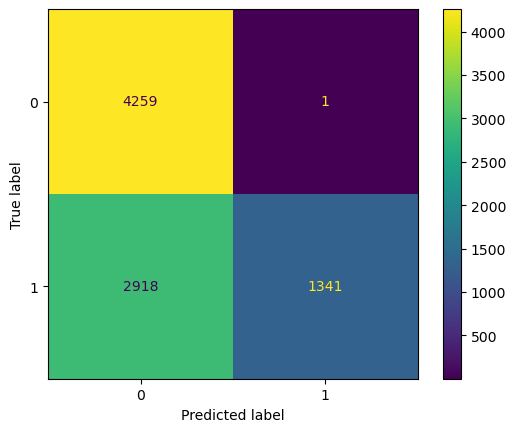

In [355]:
disp = ConfusionMatrixDisplay(confusion_matrix(df_eval["label"][:], preds[:]))
disp.plot()

In [357]:
with open("../data/preds_raw_text_final.pkl", "rb") as f:
    preds_raw = dill.load(f)

In [358]:
df_eval["pred_raw"] = preds_raw

In [359]:
df_eval

,target,source,label,pred_topic,pred_raw
0,"{""name"": ""MATH 226 - Calculus I"", ""discipline""...","```\n{\n ""name"": ""MATH 3A - Calculus I"",\n ""...",1,0,1
1,"{""name"": ""MATH 226 - Calculus I"", ""discipline""...","```\n{\n ""name"": ""MATH 109 - Calculus I"",\n ...",1,1,1
2,"{""name"": ""MATH 226 - Calculus I"", ""discipline""...","```\n{\n ""name"": ""MAT 1140 - Calculus I"",\n ...",1,0,1
3,"{""name"": ""MATH 226 - Calculus I"", ""discipline""...","{""name"": ""MATH 141 - Calculus I"", ""discipline""...",1,1,1
4,"{""name"": ""MATH 226 - Calculus I"", ""discipline""...","```\n{\n ""name"": ""MATH 150 - Calculus I"",\n ...",1,1,1
...,...,...,...,...,...
8514,"```\n{\n ""name"": ""CS 066 ASSEMBLY LANGUAGE P...","```\n{\n ""name"": ""MATH 42 - Discrete Mathemat...",0,0,0
8515,"{""name"": ""COMP-265 Assembly Language Programmi...","```\n{\n ""name"": ""MATH 253 - Discrete Mathema...",0,0,0
8516,"{""name"": ""CIS 264 Computer Organization and Sy...","{""name"": ""CS 045 DISCRETE STRUCTURES WITH COM...",0,0,0
8517,"{""name"": ""CS/IS 165 - COMPUTER ARCHITECTURE AN...","{""name"": ""CS/IS 125 - DISCRETE STRUCTURES FOR ...",0,0,0


In [ ]:
with open("../data/prediction_df.pkl", "wb") as f:
    dill.dump(df_eval, f)

# Evaluation of Equivalency Predictions

In [361]:
from sklearn.metrics import classification_report

## Raw Text Evaluation

In [370]:
print("Classification Report for Raw Text Evaluation")
print(classification_report(df_eval.iloc[:, 2], df_eval.iloc[:, 4],digits=4))

Classification Report for Raw Text Evaluation
              precision    recall  f1-score   support

           0     0.5831    0.9981    0.7361      4260
           1     0.9935    0.2862    0.4444      4259

    accuracy                         0.6422      8519
   macro avg     0.7883    0.6422    0.5903      8519
weighted avg     0.7883    0.6422    0.5903      8519



Text(0.5, 1.0, 'Raw Text Evaluation Confusion Matrix')

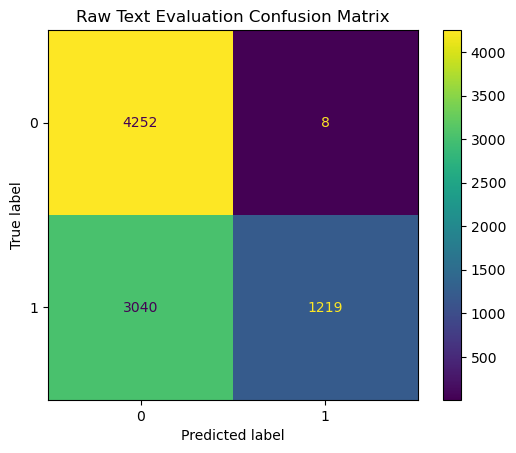

In [371]:
disp = ConfusionMatrixDisplay(confusion_matrix(df_eval["label"][:], df_eval["pred_raw"]))
disp.plot()
disp.ax_.set_title("Raw Text Evaluation Confusion Matrix")

## Discipline & Topic Evaluation

In [372]:
print("Classification Report for Discipline and Topic Evaluation")
print(classification_report(df_eval.iloc[:, 2], df_eval.iloc[:, 3],digits=4))

Classification Report for Discipline and Topic Evaluation
              precision    recall  f1-score   support

           0     0.5934    0.9998    0.7448      4260
           1     0.9993    0.3149    0.4788      4259

    accuracy                         0.6574      8519
   macro avg     0.7963    0.6573    0.6118      8519
weighted avg     0.7963    0.6574    0.6118      8519



Text(0.5, 1.0, 'Discipline/Topic Evaluation Confusion Matrix')

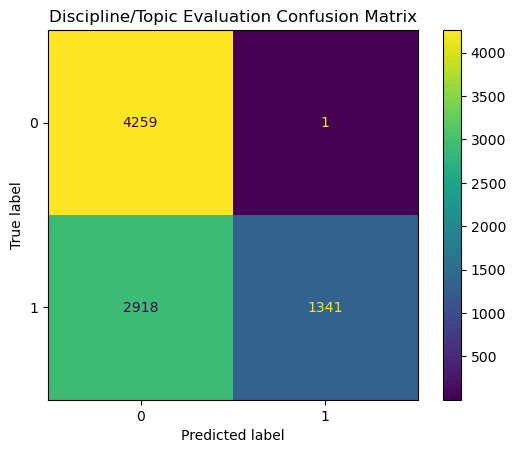

In [373]:
disp2 = ConfusionMatrixDisplay(confusion_matrix(df_eval["label"][:], df_eval["pred_topic"]))
disp2.plot()
disp2.ax_.set_title("Discipline/Topic Evaluation Confusion Matrix")

# DEPRECATED PROCESSES

#### Section: [Process Entire Dataframe](#process-entire-dataframe)

I was going to convert the dataframe into a Python dictionary to process the
data before realizing that I can just process the data directly from the dataframe.

In [ ]:
# school_courses_desc_dict = df.to_dict(orient='index')
# school_courses_desc_dict = {school:{course:(desc if type(desc) is str else None) for course,desc in courses.items()} for school,courses in school_courses_desc_dict.items()}

In [ ]:
# school_courses_desc_dict['SFSU']